# <center><h4> RecycleVision- Garbage Image Classification Using Deep Learning </center></h4>

### <u> Problem Statement </u>
Build a deep learning model that classifies images of waste into categories like plastic,metal, glass, paper, and organic.
This system will assist in automating recycling bysorting garbage based on image input, using a deep learning model deployed via a simple user interface.

#### <u> Domain </u>
Waste Management, Environmental Tech, Deep Learning, Computer Vision

#### <u> Skills </u>
Python Scripting, Deep Learning (CNN), Image Preprocessing & Augmentation, Transfer Learning, Evaluation Metrics, Streamlit App Development

### IMPORTED ALL REQUIRED LIBRARIES

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

### SETUP

In [3]:
############################################################
# 1️⃣ SETUP
############################################################

DATASET_DIR = r"C:/Users/SCAT/OneDrive/Desktop/GUVI/Garbage Image Classification using Deep Learning/garbage_classification"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

EPOCHS_FROZEN = 1
EPOCHS_FINE = 6
N_UNFREEZE = 40    # Unfreeze last 40 layers for fine-tuning

SEED = 42

### DATA CLEANING & PREPROCESSING

#### CLEAN CORRUPTED IMAGES

In [5]:
def is_valid_image(path):
    img = cv2.imread(path)
    return img is not None

print("\n Cleaning corrupted images...")
removed = 0
for cls in os.listdir(DATASET_DIR):
    folder = os.path.join(DATASET_DIR, cls)
    if not os.path.isdir(folder):
        continue
    for img in glob(folder + "/*"):
        if not is_valid_image(img):
            os.remove(img)
            removed += 1

print(f" Removed {removed} corrupted images")


 Cleaning corrupted images...
 Removed 0 corrupted images


#### DATA GENERATORS

In [15]:
train_gen = ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.20,
    rotation_range=25,
    zoom_range=0.25,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1/255.0)

train_ds = train_gen.flow_from_directory(
    DATASET_DIR, subset="training",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical", seed=SEED
)

val_ds = train_gen.flow_from_directory(
    DATASET_DIR, subset="validation",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical", seed=SEED
)

test_ds = test_gen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = len(train_ds.class_indices)
CLASS_NAMES = list(train_ds.class_indices.keys())

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Found 15515 images belonging to 12 classes.


#### CLASS WEIGHTS (Fix imbalance)

In [17]:
print("\n Calculating Class Weights...")

class_weight_vals = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_ds.classes),
    y=train_ds.classes
)

CLASS_WEIGHTS = dict(enumerate(class_weight_vals))
print(" Class Weights:", CLASS_WEIGHTS)



 Calculating Class Weights...
 Class Weights: {0: np.float64(1.3684964726631392), 1: np.float64(1.3129230118443316), 2: np.float64(2.128772290809328), 3: np.float64(1.451028517999065), 4: np.float64(0.24285993740219092), 5: np.float64(2.052744708994709), 6: np.float64(1.6795183982683983), 7: np.float64(1.2316468253968254), 8: np.float64(1.4950626204238922), 9: np.float64(0.6539717656974294), 10: np.float64(1.8540919952210275), 11: np.float64(1.6686827956989247)}


### EXPLORATORY DATA ANALYSIS (EDA)

#### Visualize number of images per class

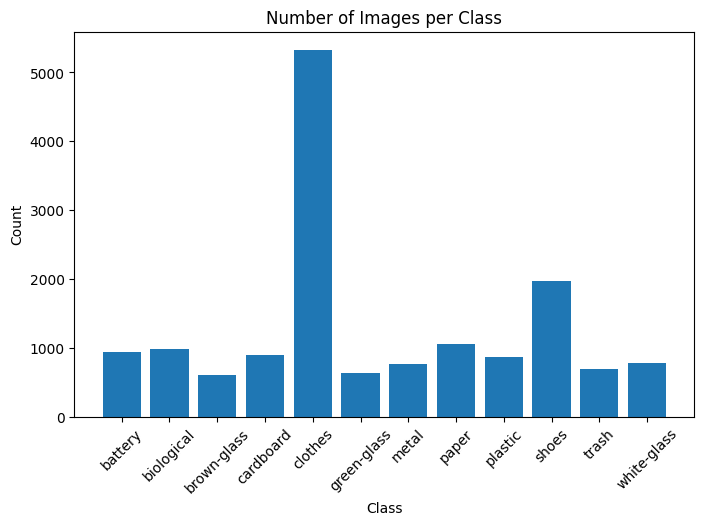

In [58]:
# Count images in each class folder
class_counts = {}
for cls in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))

# Plot
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Show example images from each category.

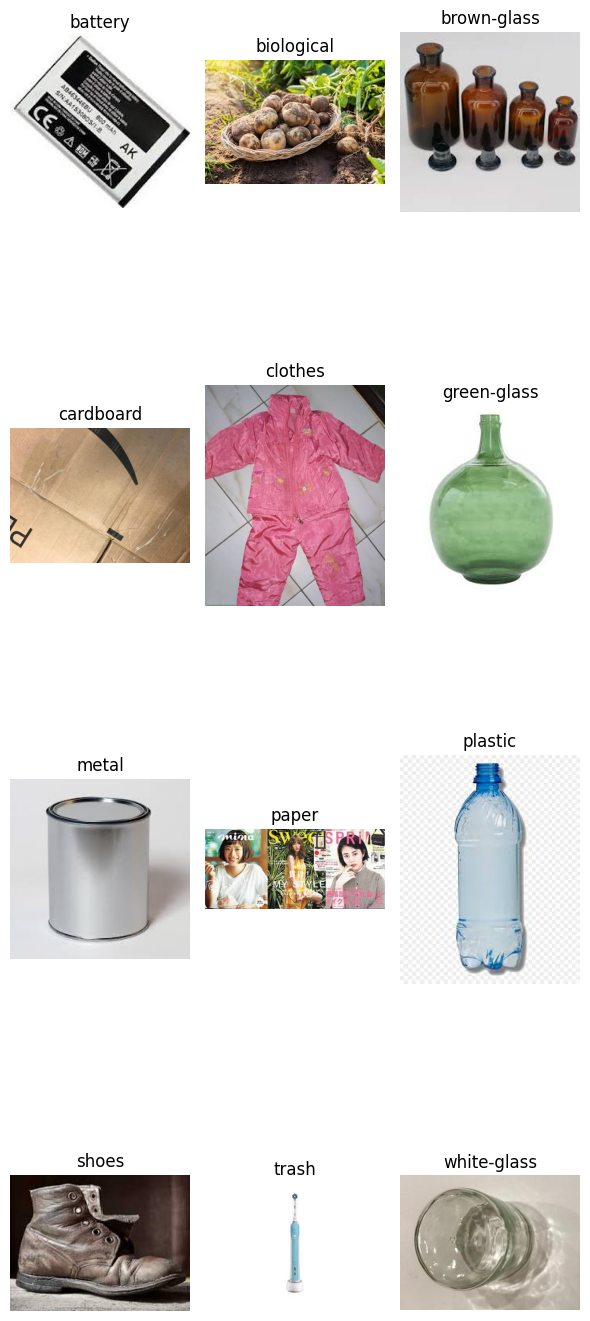

In [68]:
import cv2
import random
import matplotlib.pyplot as plt
import math

classes = [c for c in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, c))]
num_classes = len(classes)

# Determine grid size
cols = 3
rows = math.ceil(num_classes / cols)

plt.figure(figsize=(6, rows * 4))

for i, cls in enumerate(classes):
    class_path = os.path.join(DATASET_DIR, cls)

    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Analyze pixel intensity or color distribution.

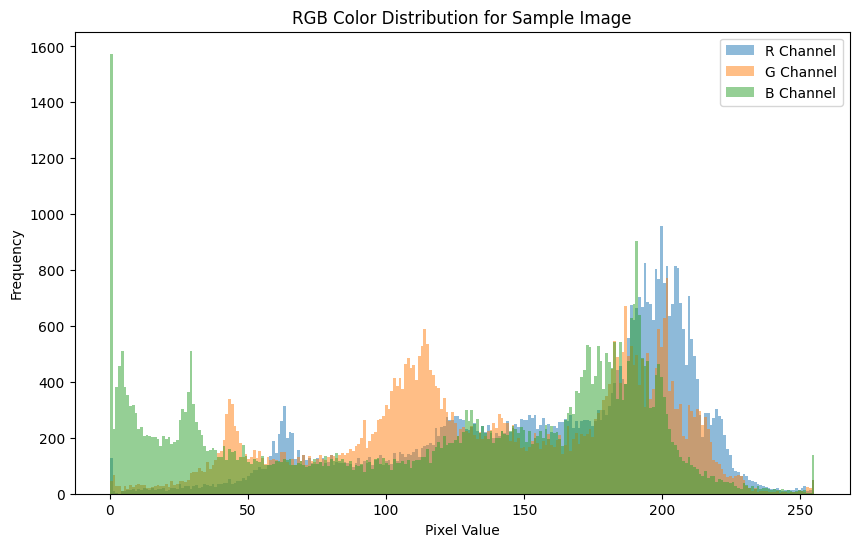

In [64]:
# Select first class as example
sample_class = os.listdir(DATASET_DIR)[0]
sample_path = os.path.join(DATASET_DIR, sample_class)
first_img = os.path.join(sample_path, os.listdir(sample_path)[0])

# Read sample image
img = cv2.imread(first_img)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot RGB distribution
plt.figure(figsize=(10,6))
for i, col in enumerate(['r', 'g', 'b']):
    plt.hist(img_rgb[:,:,i].ravel(), bins=256, alpha=0.5, label=f"{col.upper()} Channel")

plt.title('RGB Color Distribution for Sample Image')
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### MODEL BUILDER

In [19]:
def build_model(base):
    base.trainable = False  # Phase 1 frozen

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)
    out = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs=base.input, outputs=out)

    model.compile(
        optimizer=Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

### MODELS TO TRAIN

In [21]:
MODELS = {
    "EfficientNetB3": EfficientNetB3(weights="imagenet", include_top=False, input_shape=(224,224,3)),
    "MobileNetV2": MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
}

results = {}

### EVALUATION FUNCTION

In [23]:
def evaluate_model(model, name):
    preds = model.predict(test_ds)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_ds.classes

    acc = (y_pred == y_true).mean()
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    results[name] = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

    print(f"\n {name} Metrics")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")

### TRAIN ALL MODELS

In [25]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.2, verbose=1),
]

for name, base in MODELS.items():
    print(f"\n TRAINING {name}")

    model = build_model(base)

    # PHASE 1 — FROZEN
    model.fit(
        train_ds, validation_data=val_ds,
        epochs=EPOCHS_FROZEN,
        class_weight=CLASS_WEIGHTS,
        callbacks=callbacks,
        verbose=1
    )

    # PHASE 2 — FINE-TUNING
    base.trainable = True
    for layer in base.layers[:-N_UNFREEZE]:
        layer.trainable = False

    model.compile(optimizer=Adam(1e-5),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    model.fit(
        train_ds, validation_data=val_ds,
        epochs=EPOCHS_FINE,
        class_weight=CLASS_WEIGHTS,
        callbacks=callbacks,
        verbose=1
    )

    # SAVE MODEL
    model.save(f"{name}_Model.h5")

    # EVALUATE
    evaluate_model(model, name)



 TRAINING EfficientNetB3
388/388 ━━━━━━━━━━━━━━━━━━━━ 1260s 3s/step - accuracy: 0.0845 - loss: 2.4942 - val_accuracy: 0.0910 - val_loss: 2.4605 - learning_rate: 1.0000e-04
388/388 ━━━━━━━━━━━━━━━━━━━━ 1569s 4s/step - accuracy: 0.0901 - loss: 2.4712 - val_accuracy: 0.0806 - val_loss: 2.4882 - learning_rate: 1.0000e-05


485/485 ━━━━━━━━━━━━━━━━━━━━ 1159s 2s/step

 EfficientNetB3 Metrics
Accuracy  : 0.0934
Precision : 0.1861
Recall    : 0.1439
F1 Score  : 0.0489

 TRAINING MobileNetV2
388/388 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.4159 - loss: 2.0470 - val_accuracy: 0.7177 - val_loss: 1.0566 - learning_rate: 1.0000e-04
388/388 ━━━━━━━━━━━━━━━━━━━━ 854s 2s/step - accuracy: 0.6818 - loss: 1.2234 - val_accuracy: 0.7771 - val_loss: 0.7492 - learning_rate: 1.0000e-05


485/485 ━━━━━━━━━━━━━━━━━━━━ 385s 787ms/step

 MobileNetV2 Metrics
Accuracy  : 0.8503
Precision : 0.7883
Recall    : 0.7964
F1 Score  : 0.7870


### BEST MODEL

In [27]:
best_model_name = max(results, key=lambda x: results[x]["f1"])
print("\n BEST MODEL =", best_model_name)
print(" Best Metrics =", results[best_model_name])

model = tf.keras.models.load_model(f"{best_model_name}_Model.h5")



 BEST MODEL = MobileNetV2
 Best Metrics = {'accuracy': np.float64(0.8503383822107637), 'precision': 0.7883376848432891, 'recall': 0.7964336145806538, 'f1': 0.7870446198112983}


### CONFUSION MATRIX

485/485 ━━━━━━━━━━━━━━━━━━━━ 392s 798ms/step


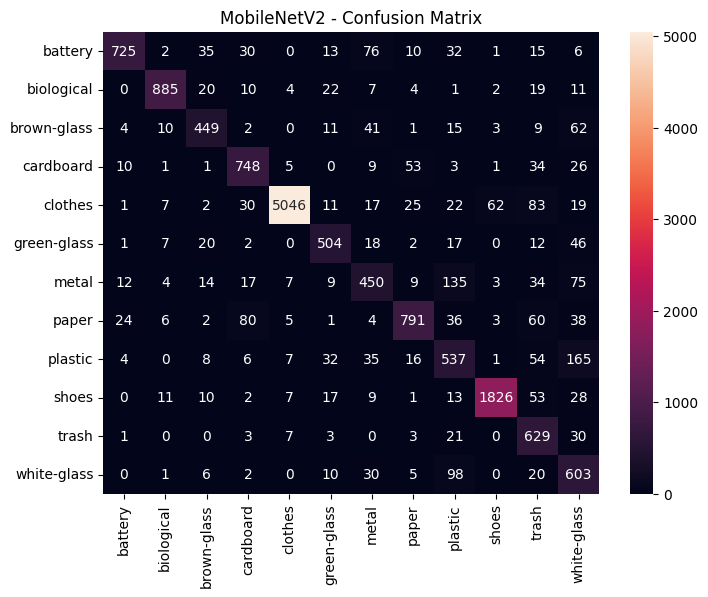

In [29]:
preds = model.predict(test_ds)
y_pred = np.argmax(preds, axis=1)
y_true = test_ds.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f"{best_model_name} - Confusion Matrix")
plt.show()

### FINAL MODEL SAVE

In [31]:
model.save("RecycleVision_BestModel.h5")
print("\n Final model saved as RecycleVision_BestModel.h5")


 Final model saved as RecycleVision_BestModel.h5
